# Vector AutoRegressive Model

## Import libraries

In [1]:
import pandas as pd
import numpy as np

## Plotting
import matplotlib.pyplot as plt
import seaborn as sns

## sklearn and statsmodels
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import acf, pacf, grangercausalitytests
from sklearn.pipeline import Pipeline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

## Import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

## Import yahoo finance
import yfinance as yf

## Import random
import random

## Read file

In [2]:
df = pd.read_csv('../Data/dataset_others.csv')
# Extract _change_in_price columns
change_in_price_cols = [col for col in df.columns if '_change_in_price' in col]
df_change = df[change_in_price_cols].copy()
df_change

,CADUSD=X_change_in_price,GM_change_in_price,JCI_change_in_price,TM_change_in_price,TRYUSD=X_change_in_price,^IXIC_change_in_price,F_change_in_price
0,-0.000418,0.099998,0.330002,-0.569992,-0.000812,15.439453,0.010000
1,0.001932,0.230000,0.160000,-0.309998,-0.000532,57.250000,0.090000
2,-0.000607,-0.139999,-0.279999,-1.449997,0.000039,-39.709961,-0.040000
3,-0.000238,-0.119999,-0.560001,0.059998,0.000314,-97.479492,-0.050000
4,-0.001081,-0.350002,-0.480000,0.459991,0.000223,-47.350586,-0.120000
...,...,...,...,...,...,...,...
1232,-0.001776,4.799999,-0.529999,0.759995,0.000026,39.759766,0.230000
1233,0.000905,-0.810001,-0.159996,1.400009,-0.000006,-303.119141,-0.049999
1234,-0.001072,-0.199997,0.379997,-0.900009,-0.000013,138.839844,0.179999
1235,-0.000866,-0.650002,-0.120003,1.570007,-0.000016,103.119141,-0.170000


## Create ticker list

In [3]:
tickers = []
for col in df.columns:
    if '_RSI' in col:
        tickers.append(col.split('_')[0])

tickers.pop()

'F'

## Train-test set

In [4]:
# Train set for cross-validation
train = df_change.iloc[:-5].copy()
# Test set is saved for the best model
test = df_change.iloc[-5:].copy()

In [5]:
train

,CADUSD=X_change_in_price,GM_change_in_price,JCI_change_in_price,TM_change_in_price,TRYUSD=X_change_in_price,^IXIC_change_in_price,F_change_in_price
0,-0.000418,0.099998,0.330002,-0.569992,-0.000812,15.439453,0.010000
1,0.001932,0.230000,0.160000,-0.309998,-0.000532,57.250000,0.090000
2,-0.000607,-0.139999,-0.279999,-1.449997,0.000039,-39.709961,-0.040000
3,-0.000238,-0.119999,-0.560001,0.059998,0.000314,-97.479492,-0.050000
4,-0.001081,-0.350002,-0.480000,0.459991,0.000223,-47.350586,-0.120000
...,...,...,...,...,...,...,...
1227,-0.001141,-0.780003,-1.080002,-5.550003,0.000020,-187.099609,-0.080000
1228,0.001146,1.160000,-0.209999,1.949997,0.000049,51.490234,0.190000
1229,0.001377,0.370003,0.860001,-0.300003,0.000026,6.529297,0.040000
1230,-0.002145,-0.200001,0.190002,0.330002,-0.000024,115.941406,0.030001


In [6]:
def optimal_order(forecast_length = 5):
    
    MSE = {}
    acc = {}
    MSE_mean = {}
    acc_mean = {}
    MSE_order = {}
    acc_order = {}
    
    cv = TimeSeriesSplit(10, test_size=forecast_length)
    
    for i in range(len(change_in_price_cols) - 1):
        tr_set = train[[change_in_price_cols[-1], change_in_price_cols[i]]].copy()
        MSE[change_in_price_cols[i]] = [[0 for col in range(40)] for row in range(10)]
        acc[change_in_price_cols[i]] = [[0 for col in range(40)] for row in range(10)]
        scaler = StandardScaler()
        scaled_train = pd.DataFrame(scaler.fit_transform(tr_set), columns = tr_set.columns)
    
        k = 0
        for train_index, test_index in cv.split(train):
            t_tt = scaled_train.iloc[train_index]
            t_ho = scaled_train.iloc[test_index]
    
            model = VAR(t_tt)
            for j in range(1, 41):
                var_model = model.fit(j)
                pred = var_model.forecast(t_tt[-j:].values, steps=forecast_length)
                MSE[change_in_price_cols[i]][k][j - 1] = np.sqrt(mean_squared_error(t_ho['F_change_in_price'].values, pred[:, 0]))
                acc[change_in_price_cols[i]][k][j - 1] = sum(pred[:, 0]*t_ho['F_change_in_price'] > 0)/len(t_ho)
            k += 1

        MSE_mean[change_in_price_cols[i]] = []
        acc_mean[change_in_price_cols[i]] = []
        MSE_mean[change_in_price_cols[i]].append(np.mean(MSE[change_in_price_cols[i]], axis=0))
        acc_mean[change_in_price_cols[i]].append(np.mean(acc[change_in_price_cols[i]], axis=0))
        MSE_order[change_in_price_cols[i]] = (np.argmin(np.mean(MSE[change_in_price_cols[i]], axis=0)) + 1)
        acc_order[change_in_price_cols[i]] = (np.argmax(np.mean(acc[change_in_price_cols[i]], axis=0)) + 1)

    return MSE, acc, MSE_mean, MSE_order, acc_mean, acc_order

In [7]:
MSE_1, acc_1, MSE_mean_1, MSE_order_1, acc_mean_1, acc_order_1 = optimal_order(1)
MSE_2, acc_2, MSE_mean_2, MSE_order_2, acc_mean_2, acc_order_2 = optimal_order(2)
MSE_3, acc_3, MSE_mean_3, MSE_order_3, acc_mean_3, acc_order_3 = optimal_order(3)
MSE_4, acc_4, MSE_mean_4, MSE_order_4, acc_mean_4, acc_order_4 = optimal_order(4)
MSE_5, acc_5, MSE_mean_5, MSE_order_5, acc_mean_5, acc_order_5 = optimal_order(5)

In [8]:
c = ['Ticker']
for i in range(1, 6):
    s = 'n = ' + str(i)
    c.append(s)
print(c)

['Ticker', 'n = 1', 'n = 2', 'n = 3', 'n = 4', 'n = 5']


In [9]:
optimal_order = pd.DataFrame(columns=c)
for i, t in enumerate(tickers):
    optimal_order.loc[i, 'Ticker'] = t.split('_')[0]
optimal_order

,Ticker,n = 1,n = 2,n = 3,n = 4,n = 5
0,CADUSD=X,NaN,NaN,NaN,NaN,NaN
1,GM,NaN,NaN,NaN,NaN,NaN
2,JCI,NaN,NaN,NaN,NaN,NaN
3,TM,NaN,NaN,NaN,NaN,NaN
4,TRYUSD=X,NaN,NaN,NaN,NaN,NaN
5,^IXIC,NaN,NaN,NaN,NaN,NaN


In [10]:
for i in range(len(change_in_price_cols) - 1):
    optimal_order.loc[i, 'n = 1'] = (max(MSE_order_1[change_in_price_cols[i]], acc_order_1[change_in_price_cols[i]]))
    optimal_order.loc[i, 'n = 2'] = (max(MSE_order_2[change_in_price_cols[i]], acc_order_2[change_in_price_cols[i]]))
    optimal_order.loc[i, 'n = 3'] = (max(MSE_order_3[change_in_price_cols[i]], acc_order_3[change_in_price_cols[i]]))
    optimal_order.loc[i, 'n = 4'] = (max(MSE_order_4[change_in_price_cols[i]], acc_order_4[change_in_price_cols[i]]))
    optimal_order.loc[i, 'n = 5'] = (max(MSE_order_5[change_in_price_cols[i]], acc_order_5[change_in_price_cols[i]]))

In [11]:
optimal_order

,Ticker,n = 1,n = 2,n = 3,n = 4,n = 5
0,CADUSD=X,2,12,5,5,5
1,GM,35,36,30,6,6
2,JCI,30,29,35,35,33
3,TM,8,26,27,21,5
4,TRYUSD=X,11,39,3,3,17
5,^IXIC,26,24,3,19,35


## Apply VAR to test set

In [12]:
df_close = df[['F_Close_pred']].copy()
prediction_cols = []
for t in tickers:
    prediction_cols.append(t + '_VAR')

predictions = pd.DataFrame(columns=prediction_cols, index=test.index)
close_predictions = predictions.copy()

In [13]:
predictions

,CADUSD=X_VAR,GM_VAR,JCI_VAR,TM_VAR,TRYUSD=X_VAR,^IXIC_VAR
1232,NaN,NaN,NaN,NaN,NaN,NaN
1233,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN
1235,NaN,NaN,NaN,NaN,NaN,NaN
1236,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
optimal_order.loc[0, optimal_order.columns[1]]

np.int64(2)

In [46]:
train.loc[-3:].values

array([[-4.18305397e-04,  9.99984741e-02,  3.30001831e-01, ...,
        -8.12456012e-04,  1.54394531e+01,  1.00002289e-02],
       [ 1.93178654e-03,  2.29999542e-01,  1.59999847e-01, ...,
        -5.32239676e-04,  5.72500000e+01,  9.00001526e-02],
       [-6.07252121e-04, -1.39999390e-01, -2.79998779e-01, ...,
         3.92049551e-05, -3.97099609e+01, -3.99999619e-02],
       ...,
       [ 1.37692690e-03,  3.70002747e-01,  8.60000610e-01, ...,
         2.58404762e-05,  6.52929688e+00,  3.99999619e-02],
       [-2.14487314e-03, -2.00000763e-01,  1.90002441e-01, ...,
        -2.36257911e-05,  1.15941406e+02,  3.00006866e-02],
       [-2.04801559e-04, -2.50000000e-01, -2.70004272e-01, ...,
        -7.15889037e-05,  5.04589844e+01, -2.20000267e-01]])

In [43]:
pd.concat([train.loc[-1:], test.loc[1232:1234]])

,CADUSD=X_change_in_price,GM_change_in_price,JCI_change_in_price,TM_change_in_price,TRYUSD=X_change_in_price,^IXIC_change_in_price,F_change_in_price
0,-0.000418,0.099998,0.330002,-0.569992,-0.000812,15.439453,0.010000
1,0.001932,0.230000,0.160000,-0.309998,-0.000532,57.250000,0.090000
2,-0.000607,-0.139999,-0.279999,-1.449997,0.000039,-39.709961,-0.040000
3,-0.000238,-0.119999,-0.560001,0.059998,0.000314,-97.479492,-0.050000
4,-0.001081,-0.350002,-0.480000,0.459991,0.000223,-47.350586,-0.120000
...,...,...,...,...,...,...,...
1230,-0.002145,-0.200001,0.190002,0.330002,-0.000024,115.941406,0.030001
1231,-0.000205,-0.250000,-0.270004,-2.360001,-0.000072,50.458984,-0.220000
1232,-0.001776,4.799999,-0.529999,0.759995,0.000026,39.759766,0.230000
1233,0.000905,-0.810001,-0.159996,1.400009,-0.000006,-303.119141,-0.049999


In [165]:
def test_validation(forecast_length = 5):
    acc = {}
    res = {}
    pred = {}

    for i in range(len(change_in_price_cols) - 1):   
        train_final = train[[change_in_price_cols[-1], change_in_price_cols[i]]].copy()
        test_final = test[[change_in_price_cols[-1], change_in_price_cols[i]]].copy()
        scaler = StandardScaler()
        scaled_train = pd.DataFrame(scaler.fit_transform(train_final), columns = train_final.columns, index = train_final.index)
        scaled_test = pd.DataFrame(scaler.transform(test_final), columns = test_final.columns, index = test_final.index)
        model = VAR(scaled_train)
        result = model.fit(optimal_order.loc[i, optimal_order.columns[forecast_length]])
        k = result.k_ar
        first_test_index = scaled_test.index[0]
        
        input_scaled = scaled_train[-k:]
        pred_evaluate = []
        j = 0
        while len(pred_evaluate) < 5:
            pred_evaluate = np.concatenate((pred_evaluate, result.forecast(input_scaled[-k:].values, steps=forecast_length)[:, 0]))
            input_scaled = pd.concat([scaled_train, scaled_test.loc[first_test_index: first_test_index + (j + 1)*forecast_length - 1]])
            j += 1
            
        # If len(pred_evaluate) > 5, delete the last values until len(pred_evaluate) == 5
        while len(pred_evaluate) > 5:
            pred_evaluate = np.delete(pred_evaluate, -1)

        pred[change_in_price_cols[i]] = pred_evaluate
        #predictions.loc[:, prediction_cols[i]] = pred_evaluate
        #close_predictions.loc[:, prediction_cols[i]] = df_close.iloc[-6]['F_Close_pred'] + predictions[prediction_cols[i]].cumsum()
        acc[change_in_price_cols[i]] = sum(pred_evaluate*scaled_test['F_change_in_price'] > 0)/len(test_final)
        res[change_in_price_cols[i]] = result
    predictions = pd.concat([pd.DataFrame(pred, index=test_final.index), scaled_test['F_change_in_price']], axis=1)
    return predictions, acc, res

In [166]:
predictions_1, acc_1, res_1 = test_validation(1)

In [167]:
predictions_1

,CADUSD=X_change_in_price,GM_change_in_price,JCI_change_in_price,TM_change_in_price,TRYUSD=X_change_in_price,^IXIC_change_in_price,F_change_in_price
1232,-0.022396,-0.030168,-0.200393,-0.081671,0.006833,0.214091,0.667098
1233,-0.000966,-0.061447,-0.200766,0.116250,0.057469,-0.192881,-0.150443
1234,0.007698,0.552943,0.217470,-0.042333,-0.063684,0.137172,0.521107
1235,-0.005664,-0.162701,0.072388,0.102681,0.090616,-0.004170,-0.500822
1236,-0.046869,-0.778185,0.110503,0.042255,-0.040358,0.081920,0.871486


In [169]:
predictions_2, acc_2, res_2 = test_validation(2)
predictions_2

,CADUSD=X_change_in_price,GM_change_in_price,JCI_change_in_price,TM_change_in_price,TRYUSD=X_change_in_price,^IXIC_change_in_price,F_change_in_price
1232,-0.102960,-0.014000,-0.181047,0.044724,-0.058000,0.220006,0.667098
1233,-0.119574,0.028550,-0.225825,0.067540,-0.019655,-0.196598,-0.150443
1234,-0.212353,0.504295,0.242934,-0.020317,0.112446,0.151461,0.521107
1235,0.012077,-0.162208,0.061414,-0.203791,-0.081629,-0.022285,-0.500822
1236,-0.095057,-0.809871,0.151448,0.171650,0.071340,0.043331,0.871486


In [170]:
predictions_3, acc_3, res_3 = test_validation(3)
predictions_3

,CADUSD=X_change_in_price,GM_change_in_price,JCI_change_in_price,TM_change_in_price,TRYUSD=X_change_in_price,^IXIC_change_in_price,F_change_in_price
1232,0.020028,-0.147398,-0.135766,0.100195,-0.028086,0.037684,0.667098
1233,-0.013446,0.040280,-0.386989,0.045142,-0.011472,0.009288,-0.150443
1234,-0.046734,-0.024545,0.063272,-0.015900,-0.016701,-0.011937,0.521107
1235,0.034039,-0.091213,-0.014834,-0.302374,0.024084,0.032707,-0.500822
1236,0.012973,-0.491521,0.378742,0.201668,-0.007136,-0.000617,0.871486


In [171]:
predictions_4, acc_4, res_4 = test_validation(4)
predictions_4

,CADUSD=X_change_in_price,GM_change_in_price,JCI_change_in_price,TM_change_in_price,TRYUSD=X_change_in_price,^IXIC_change_in_price,F_change_in_price
1232,0.020028,-0.093443,-0.135766,0.125700,-0.028086,0.173100,0.667098
1233,-0.013446,-0.001961,-0.386989,0.214455,-0.011472,-0.060164,-0.150443
1234,-0.046734,0.000852,0.063272,0.057589,-0.016701,0.168694,0.521107
1235,0.025050,-0.031283,-0.062880,-0.211292,-0.002453,0.010572,-0.500822
1236,-0.044656,-0.451110,0.358580,0.058109,-0.022613,0.009824,0.871486


In [172]:
predictions_5, acc_5, res_5 = test_validation(5)
predictions_5

,CADUSD=X_change_in_price,GM_change_in_price,JCI_change_in_price,TM_change_in_price,TRYUSD=X_change_in_price,^IXIC_change_in_price,F_change_in_price
1232,0.020028,-0.093443,-0.156427,-0.090404,0.043523,0.083584,0.667098
1233,-0.013446,-0.001961,-0.270984,0.030157,-0.055503,-0.317352,-0.150443
1234,-0.046734,0.000852,0.106941,-0.016869,0.055096,0.118671,0.521107
1235,0.025050,-0.031283,0.006105,0.035283,0.046120,-0.158540,-0.500822
1236,0.004357,0.000051,0.378433,-0.005504,0.001259,0.194957,0.871486


## Plot test accuracy

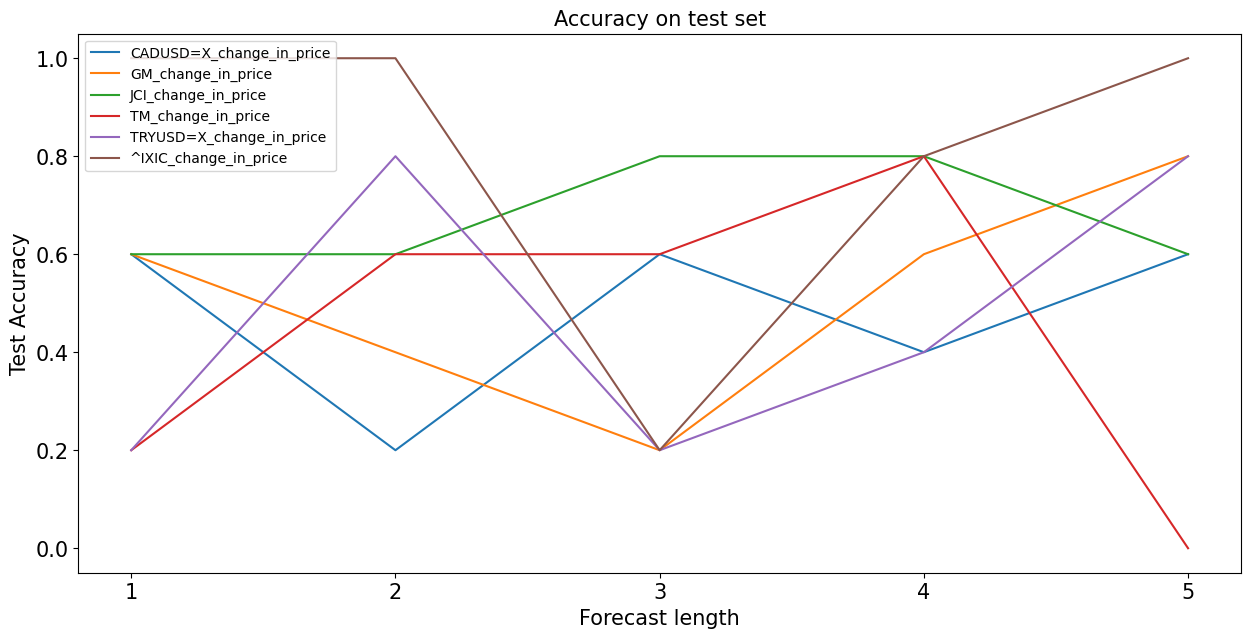

In [185]:
x = [i + 1 for i in range(5)]
plt.figure(figsize=(15, 7))
for i in range(len(predictions_1.columns)-1):
    t = predictions_1.columns[i]
    plt.plot(x, [acc_1[t], acc_2[t], acc_3[t], acc_4[t], acc_5[t]], label=t)
plt.xticks(x, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Forecast length', fontsize=15)
plt.ylabel('Test Accuracy', fontsize=15)
plt.title('Accuracy on test set', fontsize=15)
plt.legend()
plt.show()

In [186]:
res_1

{'CADUSD=X_change_in_price': <statsmodels.tsa.vector_ar.var_model.VARResultsWrapper at 0x14b3aad4d70>,
 'GM_change_in_price': <statsmodels.tsa.vector_ar.var_model.VARResultsWrapper at 0x14b3ab1e960>,
 'JCI_change_in_price': <statsmodels.tsa.vector_ar.var_model.VARResultsWrapper at 0x14b3ab1f800>,
 'TM_change_in_price': <statsmodels.tsa.vector_ar.var_model.VARResultsWrapper at 0x14b38d478c0>,
 'TRYUSD=X_change_in_price': <statsmodels.tsa.vector_ar.var_model.VARResultsWrapper at 0x14b38d47650>,
 '^IXIC_change_in_price': <statsmodels.tsa.vector_ar.var_model.VARResultsWrapper at 0x14b38d45250>}

## Backtesting

In [194]:
optimal_order

,Ticker,n = 1,n = 2,n = 3,n = 4,n = 5
0,CADUSD=X,2,12,5,5,5
1,GM,35,36,30,6,6
2,JCI,30,29,35,35,33
3,TM,8,26,27,21,5
4,TRYUSD=X,11,39,3,3,17
5,^IXIC,26,24,3,19,35


In [200]:
res = {}
for i in range(len(change_in_price_cols) - 1):
    res[change_in_price_cols[i]] = [res_1[change_in_price_cols[i]],
                                   res_2[change_in_price_cols[i]],
                                   res_3[change_in_price_cols[i]],
                                   res_4[change_in_price_cols[i]],
                                   res_5[change_in_price_cols[i]],]

In [207]:
def backtest(forecast_length=5):
    size = len(df) // 10
    rng = np.random.RandomState(42)
    acc_backtest = {}
    
    for i in range(len(change_in_price_cols) - 1):
        opt_order = optimal_order.loc[i, optimal_order.columns[forecast_length]]
        acc_backtest[change_in_price_cols[i]] = []
        for j in range(10):
            m = rng.randint(j*size + (opt_order + forecast_length), (j + 1)*size - (opt_order + forecast_length))
            backtest = df_change.iloc[m: m + opt_order][['F_change_in_price', change_in_price_cols[i]]].copy()
            test_set = df_change.iloc[m + opt_order: m + opt_order + forecast_length][['F_change_in_price', change_in_price_cols[i]]].copy()
            scaler = StandardScaler()
            scaled_train = pd.DataFrame(scaler.fit_transform(backtest), 
                                        columns = backtest.columns, 
                                        index = backtest.index)
            scaled_test = pd.DataFrame(scaler.transform(test_set), 
                                       columns = test_set.columns, 
                                       index = test_set.index)
            # Model
            result = res[change_in_price_cols[i]][forecast_length-1]
            pred = result.forecast(scaled_train.values, steps=forecast_length)
            acc_backtest[change_in_price_cols[i]].append(sum(pred[:, 0]*scaled_test['F_change_in_price'] > 0)/len(test_final))
    return acc_backtest

In [208]:
acc_backtest_1 = backtest(1)
acc_backtest_2 = backtest(2)
acc_backtest_3 = backtest(3)
acc_backtest_4 = backtest(4)
acc_backtest_5 = backtest(5)

In [209]:
acc_backtest_1

{'CADUSD=X_change_in_price': [0.0,
  0.0,
  0.2,
  0.0,
  0.0,
  0.2,
  0.0,
  0.0,
  0.2,
  0.0],
 'GM_change_in_price': [0.0, 0.2, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0],
 'JCI_change_in_price': [0.0, 0.2, 0.0, 0.2, 0.2, 0.0, 0.2, 0.2, 0.2, 0.2],
 'TM_change_in_price': [0.2, 0.2, 0.2, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.0],
 'TRYUSD=X_change_in_price': [0.0,
  0.0,
  0.2,
  0.2,
  0.0,
  0.0,
  0.2,
  0.2,
  0.2,
  0.0],
 '^IXIC_change_in_price': [0.2, 0.0, 0.2, 0.2, 0.0, 0.2, 0.2, 0.2, 0.2, 0.2]}

In [217]:
acc_backtest_mean = optimal_order.copy()
acc_backtest_std = optimal_order.copy()

In [218]:
for i in range(len(change_in_price_cols) - 1):
    acc_backtest_mean.loc[i, 'n = 1'] = np.mean(acc_backtest_1[change_in_price_cols[i]])
    acc_backtest_mean.loc[i, 'n = 2'] = np.mean(acc_backtest_2[change_in_price_cols[i]])
    acc_backtest_mean.loc[i, 'n = 3'] = np.mean(acc_backtest_3[change_in_price_cols[i]])
    acc_backtest_mean.loc[i, 'n = 4'] = np.mean(acc_backtest_4[change_in_price_cols[i]])
    acc_backtest_mean.loc[i, 'n = 5'] = np.mean(acc_backtest_5[change_in_price_cols[i]])

    acc_backtest_std.loc[i, 'n = 1'] = np.std(acc_backtest_1[change_in_price_cols[i]])
    acc_backtest_std.loc[i, 'n = 2'] = np.std(acc_backtest_2[change_in_price_cols[i]])
    acc_backtest_std.loc[i, 'n = 3'] = np.std(acc_backtest_3[change_in_price_cols[i]])
    acc_backtest_std.loc[i, 'n = 4'] = np.std(acc_backtest_4[change_in_price_cols[i]])
    acc_backtest_std.loc[i, 'n = 5'] = np.std(acc_backtest_5[change_in_price_cols[i]])

In [222]:
acc_backtest_mean

,Ticker,n = 1,n = 2,n = 3,n = 4,n = 5
0,CADUSD=X,0.06,0.28,0.32,0.5,0.68
1,GM,0.1,0.24,0.38,0.42,0.48
2,JCI,0.14,0.2,0.36,0.48,0.74
3,TM,0.14,0.2,0.24,0.48,0.52
4,TRYUSD=X,0.1,0.2,0.28,0.32,0.62
5,^IXIC,0.16,0.22,0.3,0.48,0.44


In [235]:
acc_backtest_mean[acc_backtest_mean.Ticker=='CADUSD=X'].values

array([['CADUSD=X', np.float64(0.06000000000000001), np.float64(0.28),
        np.float64(0.31999999999999995), np.float64(0.5),
        np.float64(0.68)]], dtype=object)

In [230]:
acc_backtest_mean.loc[0][1:]

n = 1    0.06
n = 2    0.28
n = 3    0.32
n = 4     0.5
n = 5    0.68
Name: 0, dtype: object

In [243]:
x = [i + 1 for i in range(5)]
mean_df = acc_backtest_mean.drop('Ticker', axis=1).copy()
std_df = acc_backtest_std.drop('Ticker', axis=1).copy()

In [244]:
mean_df

,n = 1,n = 2,n = 3,n = 4,n = 5
0,0.06,0.28,0.32,0.5,0.68
1,0.1,0.24,0.38,0.42,0.48
2,0.14,0.2,0.36,0.48,0.74
3,0.14,0.2,0.24,0.48,0.52
4,0.1,0.2,0.28,0.32,0.62
5,0.16,0.22,0.3,0.48,0.44


AttributeError: Line2D.set() got an unexpected keyword argument 'legend'

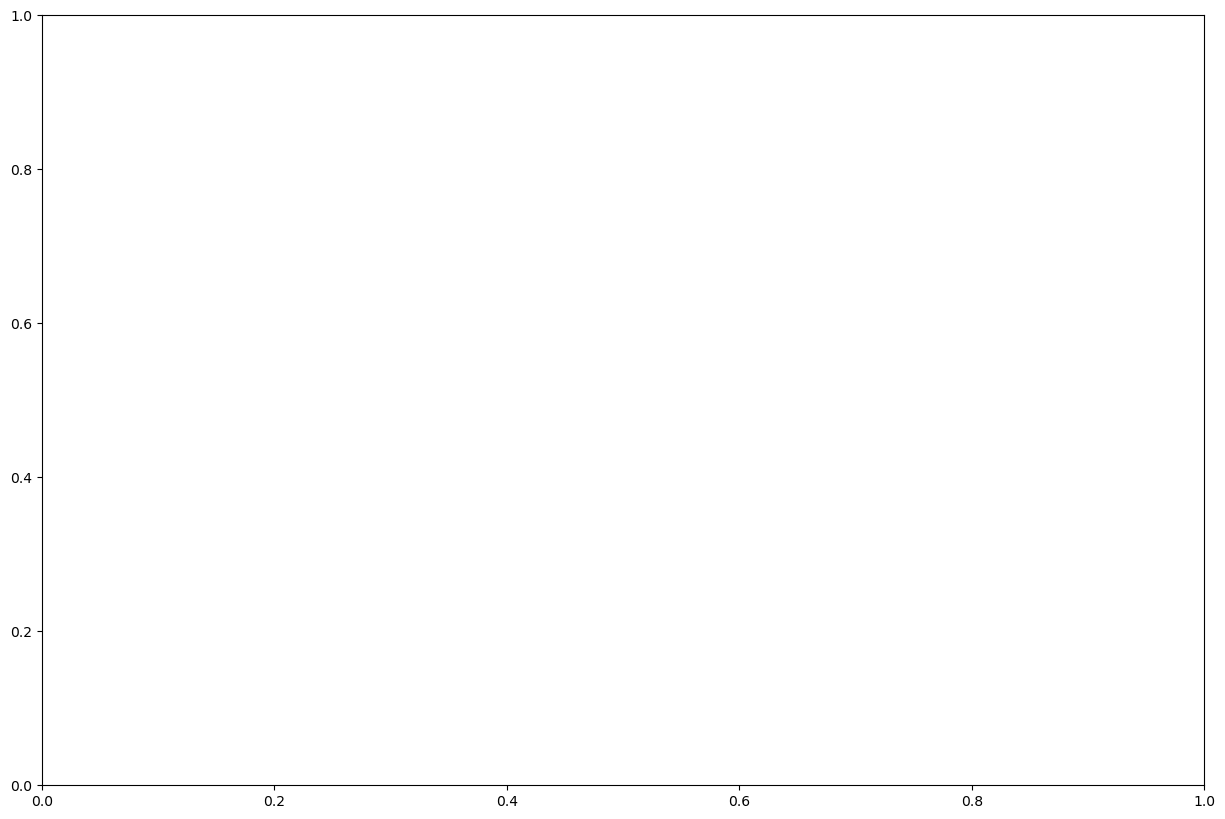

In [251]:
x = [i + 1 for i in range(5)]

plt.figure(figsize=(15,10))
for i in range(len(change_in_price_cols) - 1):
    t = acc_backtest_mean.loc[i, 'Ticker']
    m = mean_df.iloc[i].to_numpy()
    s = std_df.iloc[i].to_numpy()
    plt.errorbar(x, m, yes, legend=t)
plt.legend()
plt.show()